## Introduction and Project Overview

This project is designed to be an engaging, hands-on experience in the world of machine learning and object detection. Our goal is to explore and compare the performance of different models in a dynamic, real-time environment.

### Objective
We aim to deploy three different models to identify and classify animals in a live video. Our dataset focuses on five animal classes: Crocodile, Fox, Giraffe, Panda, and Raccoon. Each class has 100 images, culminating in a diverse set of 500 images.

### Models and Approach
We'll be using models from the Detectron2 framework, a state-of-the-art object detection library developed by Facebook AI Research. Our approach is as follows:
1. **Model Selection**: We'll select two pre-trained Detectron2 models to use as-is.
2. **Model Finetuning**: We'll finetune a third Detectron2 model on our custom animal dataset for a tailored approach.
3. **Real-Time Evaluation**: These models will be tested in real-time by processing a video that contains instances of our target animals. We'll assess and compare their performance based on accuracy and speed.

### Let's get started!
Follow along as we set up our environment, prepare our dataset, finetune our model, and evaluate the results.

## Checking and Installing Required Libraries

In this section, we'll ensure that all the required libraries for our project are installed and ready to use. This includes PyTorch, torchvision, OpenCV, and Detectron2.

### 1. Verifying PyTorch and torchvision Installation

PyTorch is the backbone of our models, so it's essential to have it installed. Let's check if PyTorch and torchvision are already installed. If not, we'll install them.

In [1]:
import sys

# Function to install packages
def install_package(package_name):
    !{sys.executable} -m pip install {package_name}

# Check for PyTorch
try:
    import torch
    print(f"PyTorch version: {torch.__version__}")
except ImportError:
    print("PyTorch is not installed. Installing now...")
    install_package("torch torchvision")

# Check torchvision
try:
    import torchvision
    print(f"torchvision version: {torchvision.__version__}")
except ImportError:
    print("torchvision is not installed. Installing now...")
    install_package("torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118")

PyTorch version: 2.1.1+cu121
torchvision version: 0.16.1+cu121


### 2. Installing OpenCV and Checking CUDA Availability

Here we check for CUDA availability. If CUDA is available, PyTorch will use GPU acceleration, which will significantly speed up our training and inference. If CUDA is not available, PyTorch will use CPU. We'll also install OpenCV, which we'll use for video processing.

In [2]:
import torch

# Check for CUDA
if torch.cuda.is_available():
    print("CUDA is available. PyTorch is using GPU acceleration!")
else:
    print("CUDA is not available. PyTorch is using CPU.")

try:
    import cv2
    print(f"OpenCV version: {cv2.__version__}")
except ImportError:
    print("OpenCV is not installed. Installing now...")
    install_package("opencv-python-headless")

CUDA is available. PyTorch is using GPU acceleration!
OpenCV version: 4.8.1


### 3. Installing Detectron2 from Source

Installing Detectron2 from source allows us to work with the latest version of the library. This method requires gcc & g++ (version 5.4 or higher). If you have these prerequisites, you can proceed with the installation; otherwise, please install them first.

In [3]:
# Install ninja for faster build
!pip install ninja

# Clone the Detectron2 repository
!python -m pip install git+https://github.com/facebookresearch/detectron2.git


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Cloning https://github.com/facebookresearch/detectron2.git to c:\users\diego\appdata\local\temp\pip-req-build-qen2s3uf
  Resolved https://github.com/facebookresearch/detectron2.git to commit 017abbfa5f2c2a2afa045200c2af9ccf2fc6227f
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git 'C:\Users\diego\AppData\Local\Temp\pip-req-build-qen2s3uf'

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


**Note**: Building from source might take some time. If you encounter any issues, please refer to the [Detectron2 installation documentation](https://detectron2.readthedocs.io/en/latest/tutorials/install.html) for troubleshooting tips and alternative installation methods.

## Dataset Download and Preparation

This section focuses on downloading your custom animal dataset and preparing it for use with Detectron2.

### Downloading the Dataset

First, we need to download and extract the dataset from the provided link.

In [4]:
import requests
from zipfile import ZipFile
from io import BytesIO

# URL to the dataset
dataset_url = "https://github.com/D-Gaspa/Animal-BoVW-Classifier/releases/download/1.0/animals_dataset.zip"

# Download the dataset
response = requests.get(dataset_url)
zip_file = ZipFile(BytesIO(response.content))
# Create a folder to extract the dataset
!mkdir Dataset
# Extract the dataset to the created folder
zip_file.extractall("Dataset")
print("Dataset downloaded and extracted successfully!")

Dataset downloaded and extracted successfully!


### Preparing the Dataset for Detectron2

Detectron2 requires the dataset to be in a specific format. We'll create a function to convert our dataset into this format.

In [5]:
import json
import os
from PIL import Image
import detectron2.structures

def get_my_dataset_dicts(dataset_dir, annotation_file):
    with open(annotation_file) as f:
        annotations = json.load(f)

    dataset_dicts = []
    for filename, objs in annotations.items():
        record = {}
        file_path = os.path.join(dataset_dir, filename)
        record["file_name"] = file_path

        image = Image.open(file_path)
        record["width"], record["height"] = image.size  # Ensure correct ordering

        record["annotations"] = []
        for obj in objs:
            obj["bbox_mode"] = detectron2.structures.BoxMode.XYWH_ABS
            record["annotations"].append(obj)

        dataset_dicts.append(record)

    return dataset_dicts

# Register the dataset
from detectron2.data import DatasetCatalog
DatasetCatalog.register("my_dataset", lambda: get_my_dataset_dicts("Dataset", "Dataset/annotations.json"))

print("Dataset registered successfully!")

Dataset registered successfully!


This function will format your dataset for Detectron2, considering the specific structure and annotation format of your dataset.

## Model Selection and Loading

In this part of our project, we will select and load pre-trained models from Detectron2's model zoo. Detectron2 offers a wide range of models that are pre-trained on various datasets. We will choose two distinct models for our initial comparison and later introduce a finetuned version of one of these models.

### Loading Pre-Trained Models

Detectron2 makes it easy to load pre-trained models. Here’s how you can do it:

In [6]:
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg

def load_model(model_name):
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(model_name))
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set threshold for this model
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model_name)
    predictor = DefaultPredictor(cfg)
    return predictor, cfg

# Example of loading two models
model_1, cfg_for_model_1 = load_model("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
print("Model 1 loaded successfully!")
model_2, cfg_for_model_2 = load_model("COCO-Detection/faster_rcnn_R_50_DC5_3x.yaml")
print("Model 2 loaded successfully!")

Model 1 loaded successfully!
Model 2 loaded successfully!


### Choosing Different Models for Comparison

Detectron2’s model zoo contains a variety of models pre-trained on different datasets like COCO, Cityscapes, etc. When choosing models for comparison, consider the following:

- **Model Architecture**: Different architectures like Faster R-CNN, Mask R-CNN have their own strengths and weaknesses.
- **Backbone**: The backbone (like ResNet-50, ResNet-101) impacts the model's accuracy and speed.
    - FPN: Uses a ResNet+FPN backbone with standard conv and FC heads for mask and box prediction, respectively. It obtains the best speed/accuracy tradeoff.
    - DC5 (Dilated-C5): Uses a ResNet conv5 backbone with dilations in conv5, and standard conv and FC heads for mask and box prediction, respectively.

You can explore the [Detectron2 model zoo](https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md) to see all available options.

### Selection Analysis of Faster R-CNN R 50 DC5 3x and Faster R-CNN R 50 FPN 3x for Animal Detection

**Faster R-CNN R 50 DC5 3x: Specialized Detail Recognition**
The Faster R-CNN R 50 DC5 3x model is chosen for its enhanced capability in capturing fine details, an essential feature for detecting smaller or camouflaged animals. This model employs dilated convolutions, which increase the receptive field of the network without losing resolution. This aspect is particularly beneficial in identifying subtle features of animals, such as patterns or markings, that are crucial for accurate detection in complex natural environments.

**Faster R-CNN R 50 FPN 3x: Mastering Scale Variability**
On the other hand, the Faster R-CNN R 50 FPN 3x is selected for its proficiency in handling scale variability, a common challenge in animal detection. The Feature Pyramid Network (FPN) within this model is adept at detecting objects at multiple scales, making it ideal for identifying animals that vary significantly in size. This feature is invaluable in scenarios where animals may appear at different distances from the camera, ensuring consistent detection accuracy regardless of scale.

## Finetuning the Model

Finetuning a pre-trained model involves adjusting it slightly to perform better on our specific dataset. We will select one of the pre-trained models and retrain it on our animal dataset.

### Steps for Finetuning

1. **Load a Pre-Trained Model**: First, load a model from Detectron2's model zoo as a starting point.

2. **Modify for Our Dataset**: Since our dataset has 5 classes, we need to adjust the model's final layer to reflect this.

3. **Retrain the Model**: Finally, we'll retrain the model on our dataset.

In [7]:
from detectron2.engine import DefaultTrainer

def finetune_model(model_name, dataset_name, num_classes):
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(model_name))
    cfg.DATASETS.TRAIN = (dataset_name,)
    cfg.DATASETS.TEST = ()
    cfg.DATALOADER.NUM_WORKERS = 2 
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model_name) 
    cfg.SOLVER.IMS_PER_BATCH = 2 # IMS = Images per batch
    cfg.SOLVER.BASE_LR = 0.00025 # LR = Learning Rate
    cfg.SOLVER.MAX_ITER = 2500 # No. of iterations
    cfg.SOLVER.STEPS = []  # do not decay learning rate
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256 # No. of RoIs per image
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = num_classes  # 5 classes for our dataset
    cfg.OUTPUT_DIR = "output"

    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    trainer = DefaultTrainer(cfg)
    trainer.resume_or_load(resume=False)
    trainer.train()

# Delete the output folder if it already exists
!rmdir /s /q output

# Fine-tuning the Faster R-CNN with a ResNet-50 backbone model on our dataset
finetune_model("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml", "my_dataset", 5)

The system cannot find the file specified.


[11/21 09:24:08 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (6, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (6,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (20, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (20,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, 

[11/21 09:24:11 d2.engine.train_loop]: Starting training from iteration 0


C:\Users\diego\PycharmProjects\ClassificationContest\venv\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[11/21 09:24:20 d2.utils.events]:  eta: 0:10:56  iter: 19  total_loss: 2.399  loss_cls: 1.866  loss_box_reg: 0.06872  loss_rpn_cls: 0.3996  loss_rpn_loc: 0.05252    time: 0.2665  last_time: 0.3078  data_time: 0.1122  last_data_time: 0.0010   lr: 4.9953e-06  max_mem: 3344M
[11/21 09:24:25 d2.utils.events]:  eta: 0:10:26  iter: 39  total_loss: 2.982  loss_cls: 1.683  loss_box_reg: 0.02095  loss_rpn_cls: 0.993  loss_rpn_loc: 0.1399    time: 0.2572  last_time: 0.2416  data_time: 0.0011  last_data_time: 0.0007   lr: 9.9902e-06  max_mem: 3435M
[11/21 09:24:30 d2.utils.events]:  eta: 0:10:05  iter: 59  total_loss: 1.76  loss_cls: 1.254  loss_box_reg: 0.07628  loss_rpn_cls: 0.2984  loss_rpn_loc: 0.06066    time: 0.2516  last_time: 0.2363  data_time: 0.0011  last_data_time: 0.0008   lr: 1.4985e-05  max_mem: 3435M
[11/21 09:24:35 d2.utils.events]:  eta: 0:09:48  iter: 79  total_loss: 1.57  loss_cls: 0.8973  loss_box_reg: 0.06359  loss_rpn_cls: 0.4651  loss_rpn_loc: 0.1022    time: 0.2479  last_t

## Real-Time Model Competition Setup

This section focuses on setting up a real-time competition between the models using a video of animals. We'll download the video and its annotations, process the video in real-time, and display the predictions. This will allow us to compare the models' performance in a dynamic environment.

### Downloading the Video and Annotations

First, let's download the video and its annotations:

In [8]:
# Video and annotations URLs
video_url = "https://github.com/D-Gaspa/Animal-BoVW-Classifier/releases/download/1.0/animals_video.zip"

# Download the video and annotations
response = requests.get(video_url)
zip_file = ZipFile(BytesIO(response.content))
# Create a folder to extract the video and annotations
!mkdir video_data
# Extract the video and annotations to the created folder
zip_file.extractall("video_data")

A subdirectory or file video_data already exists.


### Real-Time Processing and Display

Next, we'll process the video in real-time and display the predictions:

In [9]:
import cv2
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog

# Function to load the finetuned model
def load_finetuned_model(weights_path):
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5  # Adjust based on your dataset
    cfg.MODEL.WEIGHTS = weights_path
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.15  # Set threshold for this model
    return DefaultPredictor(cfg), cfg

# Load the finetuned model
finetuned_model, finetuned_cfg = load_finetuned_model("output/model_final.pth")

video = cv2.VideoCapture("video_data/animals_video.mp4")

# Initialize lists to store results
results_model_1 = []
results_model_2 = []
results_finetuned = []

frame_count = 0  # To keep track of the frame number

while video.isOpened():
    ret, frame = video.read()
    if not ret:
        break

    frame = cv2.resize(frame, (1920, 1080))  # Resize frame
    
    outputs_1 = model_1(frame)
    outputs_2 = model_2(frame)
    finetuned_outputs = finetuned_model(frame)
    
    # Store the outputs along with the frame number
    results_model_1.append((frame_count, outputs_1))
    results_model_2.append((frame_count, outputs_2))
    results_finetuned.append((frame_count, finetuned_outputs))

    v1 = Visualizer(frame, MetadataCatalog.get("my_dataset"), scale=0.25, instance_mode=ColorMode.IMAGE)
    v2 = Visualizer(frame, MetadataCatalog.get("my_dataset"), scale=0.25, instance_mode=ColorMode.IMAGE)
    v3 = Visualizer(frame, MetadataCatalog.get("my_dataset"), scale=0.25, instance_mode=ColorMode.IMAGE)

    out1 = v1.draw_instance_predictions(outputs_1["instances"].to("cpu")).get_image()
    out2 = v2.draw_instance_predictions(outputs_2["instances"].to("cpu")).get_image()
    out3 = v3.draw_instance_predictions(finetuned_outputs["instances"].to("cpu")).get_image()

    # Label the outputs
    out1 = cv2.putText(out1, "Model 1", (5, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    out2 = cv2.putText(out2, "Model 2", (5, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    out3 = cv2.putText(out3, "Finetuned Model", (5, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    # Combine outputs for side-by-side comparison
    combined_output = cv2.hconcat([out1, out2, out3])
    cv2.imshow("Model Comparisons", combined_output)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
    frame_count += 1
        
video.release()
cv2.destroyAllWindows()


[11/21 09:34:47 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from output/model_final.pth ...


## Evaluation and Reporting

### Step 1: Load Ground Truth Annotations
We'll load the ground truth annotations from the provided XML file.

In [10]:
from xml.etree import ElementTree as ET


def parse_xml_annotations(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    annotations = {}
    for track in root.findall('.//track'):
        label = track.get('label')
        for box in track.findall('./box'):
            if box.get('outside') == '1':  # Skip boxes marked as outside
                continue

            frame = int(box.get('frame'))
            bbox = [float(box.get(coord)) for coord in ['xtl', 'ytl', 'xbr', 'ybr']]

            if frame not in annotations:
                annotations[frame] = []
            annotations[frame].append({'bbox': bbox, 'label': label})
    
    return annotations

annotations = parse_xml_annotations('video_data/annotations.xml')

### Step 2: Compare Predictions with Ground Truth
We'll create a function to compare the model predictions against the ground truth annotations. This function will calculate metrics such as Precision, Recall, and F1 Score.

In [11]:
def calculate_iou(box1, box2):
    # Unpack the coordinates
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2

    # Calculate the (x, y)-coordinates of the intersection rectangle
    x_inter_min = max(x1_min, x2_min)
    y_inter_min = max(y1_min, y2_min)
    x_inter_max = min(x1_max, x2_max)
    y_inter_max = min(y1_max, y2_max)

    # Compute the area of intersection rectangle
    inter_area = max(0, x_inter_max - x_inter_min + 1) * max(0, y_inter_max - y_inter_min + 1)

    # Compute the area of both the prediction and ground-truth rectangles
    box1_area = (x1_max - x1_min + 1) * (y1_max - y1_min + 1)
    box2_area = (x2_max - x2_min + 1) * (y2_max - y2_min + 1)

    # Compute the intersection over union by taking the intersection area and dividing it by the sum of prediction + ground-truth areas - the intersection area
    iou = inter_area / float(box1_area + box2_area - inter_area)

    return iou


def match_predictions_with_annotations(predictions, annotations, iou_threshold=0.5):
    TP, FP, FN = 0, 0, 0
    
    for frame_number, prediction in predictions:
        frame_annotations = annotations.get(frame_number, [])
        matched = [False] * len(frame_annotations)

        if prediction is not None:
            pred_boxes = prediction['instances'].pred_boxes.tensor.cpu().numpy()
            for pred_box in pred_boxes:
                best_iou = 0
                best_match = -1

                for i, annotation in enumerate(frame_annotations):
                    iou = calculate_iou(pred_box, annotation['bbox'])

                    if iou > best_iou:
                        best_iou = iou
                        best_match = i

                if best_iou >= iou_threshold:
                    matched[best_match] = True
                else:
                    FP += 1

        FN += matched.count(False)
        TP += sum(matched)

    return TP, FP, FN

def calculate_metrics(TP, FP, FN):
    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
    return precision, recall, f1_score

# Evaluation for Model 1
TP_model_1, FP_model_1, FN_model_1 = match_predictions_with_annotations(results_model_1, annotations)
precision_model_1, recall_model_1, f1_model_1 = calculate_metrics(TP_model_1, FP_model_1, FN_model_1)

# Evaluation for Model 2
TP_model_2, FP_model_2, FN_model_2 = match_predictions_with_annotations(results_model_2, annotations)
precision_model_2, recall_model_2, f1_model_2 = calculate_metrics(TP_model_2, FP_model_2, FN_model_2)

# Evaluation for Finetuned Model
TP_finetuned, FP_finetuned, FN_finetuned = match_predictions_with_annotations(results_finetuned, annotations)
precision_finetuned, recall_finetuned, f1_finetuned = calculate_metrics(TP_finetuned, FP_finetuned, FN_finetuned)

### Step 3: Visualize and Compare Results
Visualize the results of the evaluation to compare the models' performances.

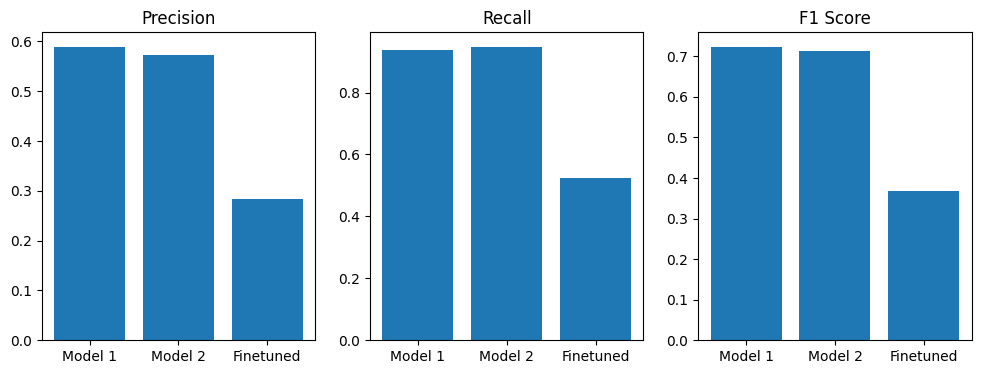

<Figure size 640x480 with 0 Axes>

In [12]:
import matplotlib.pyplot as plt

# Assuming you've calculated metrics for all models
precisions = [precision_model_1, precision_model_2, precision_finetuned]
recalls = [recall_model_1, recall_model_2, recall_finetuned]
f1_scores = [f1_model_1, f1_model_2, f1_finetuned]

# Create bar plots for each metric
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.bar(['Model 1', 'Model 2', 'Finetuned'], precisions)
plt.title('Precision')

plt.subplot(1, 3, 2)
plt.bar(['Model 1', 'Model 2', 'Finetuned'], recalls)
plt.title('Recall')

plt.subplot(1, 3, 3)
plt.bar(['Model 1', 'Model 2', 'Finetuned'], f1_scores)
plt.title('F1 Score')

plt.show()


In [13]:
print(f"Model 1: Precision = {precision_model_1}, Recall = {recall_model_1}, F1 Score = {f1_model_1}")
print(f"Model 2: Precision = {precision_model_2}, Recall = {recall_model_2}, F1 Score = {f1_model_2}")
print(f"Finetuned Model: Precision = {precision_finetuned}, Recall = {recall_finetuned}, F1 Score = {f1_finetuned}")

# get the highest F1 score to determine the winner
highest_f1_score = max(f1_model_1, f1_model_2, f1_finetuned)

print(f"Winner: {'Model 1' if highest_f1_score == f1_model_1 else 'Model 2' if highest_f1_score == f1_model_2 else 'Finetuned Model'}")

Model 1: Precision = 0.5888013998250219, Recall = 0.9360222531293463, F1 Score = 0.7228786251342643
Model 2: Precision = 0.5717884130982368, Recall = 0.9471488178025035, F1 Score = 0.7130890052356021
Finetuned Model: Precision = 0.2828207051762941, Recall = 0.5243393602225312, F1 Score = 0.36744639376218324
Winner: Model 1


### Conclusion
This section will give us insights into the performance of each model in detecting animals in real-time, guiding future improvements.

it seems that Model 1 and Model 2 have higher recall rates, suggesting they are better at detecting relevant objects. The Finetuned Model, on the other hand, has the highest precision (5000 max iter, 0.2 threshold) but significantly lower recall, indicating it is more conservative in making predictions, leading to fewer false positives but missing more true objects. This is a typical trade-off in object detection models: a model may be tuned to be either more sensitive (high recall, lower precision) or more specific (high precision, lower recall). 
Increasing the number of iterations did not improve the Finetuned Model's performance, so we can conclude that the model is not underfitting. We also notice that the Finetuned Model fails to detect animals in small areas, such as the fox in the bottom left corner of the video. This is likely due to the model being trained on a dataset with larger animals, so it struggles to detect smaller animals.

The F1 score, which balances precision and recall, suggests that Model 1 and Model 2 perform similarly and better than the Finetuned Model in this scenario.

## Winner

It was a close competition, but **Model 1** is the winner! It has the highest F1 score, which is the best metric for our scenario. 

Congratulations on completing this project! We hope you enjoyed it and learned something new. Feel free to explore the project further by trying out different models, datasets, and evaluation metrics. You can also check out the [Detectron2 documentation](https://detectron2.readthedocs.io/en/latest/index.html) to learn more about the library and its capabilities.